In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-image-classification-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5353029%2F8903857%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T162256Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db878c4dad1c21ff08d0e0b408314d8c747092efc59d7c7458eff3958769bd59b654f9d4ba471a7de9bc0ee47f9abd48619eef9a593d0d8e7160e62e5abd8940632024dda6ed0a82033c658799269a3195bb32e6bffd07d20c856904fe6544dbe9c03af9a6b73146fe2e6d0f5b62b1a28a02b8d0554e662011f3f5a5e91660d52ad55187f0ad481b89fd3572f0ca3b8ef01b015c05bb7cc5da847aa5288b4d5d3595f41c33c8d3485b6c1599b4614fbdbc30ae5e9f9e3b47dc69a8e546b3fc45943d816e19945021900ff9ae4baea6ed28c3d8bd6f547b2303c713cf712d3686527dbea597c8d9452c6f9087e12fd38c47678e99f82c7b162531bee5436c69d1e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, tensorflow as tf, numpy as np, matplotlib.pyplot as plt, pandas as pd, cv2, keras
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

print(tf.__version__)

2.17.0


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input/animal-image-classification-dataset/Animals'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0107.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0381.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0740.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0609.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0751.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0105.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0026.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0589.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0209.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0113.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0121.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0650.jpg
/kaggle/input/animal-image-classification-dataset/Animals/cats/0_0037.jpg
/kaggle/input/animal-image-classificat

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Parameter
ds_path = "/kaggle/input/animal-image-classification-dataset/Animals"
sz = 150
rs = 42
bs = 32
lr = 0.001


fldr = os.listdir(ds_path)
print(f"Folders in 'ds_path':\n{os.listdir(ds_path)}")
print()


Folders in 'ds_path':
['cats', 'dogs', 'snakes']



Amount of Images: 3000
Amount of Labels: 3000
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]

Training Set Size:
X: (2400, 150, 150, 3)
Y: (2400, 3)

Test Set Size:
X: (600, 150, 150, 3)
Y: (600, 3)
First 5 cats images:


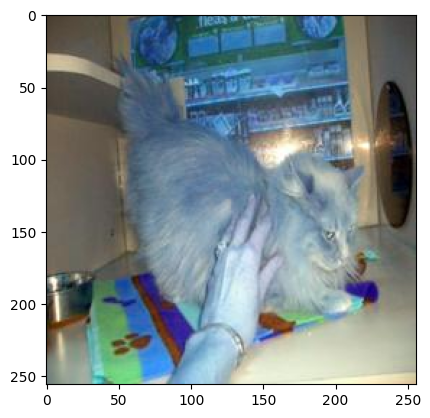

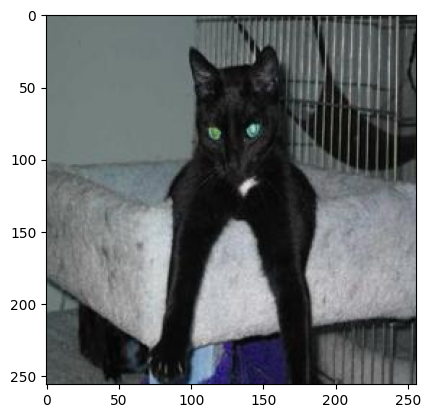

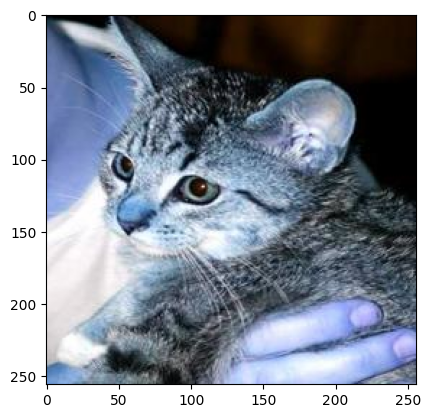

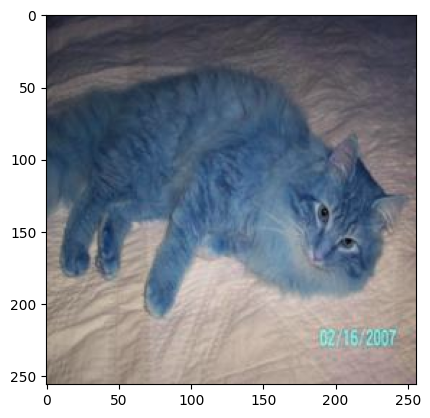

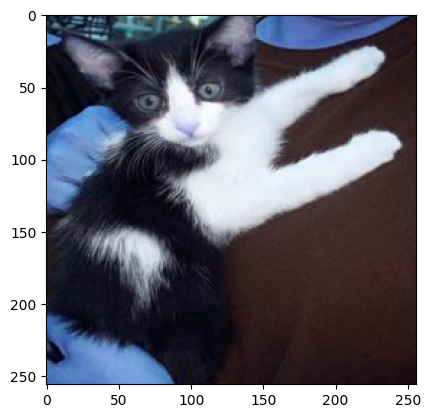

First 5 dogs images:


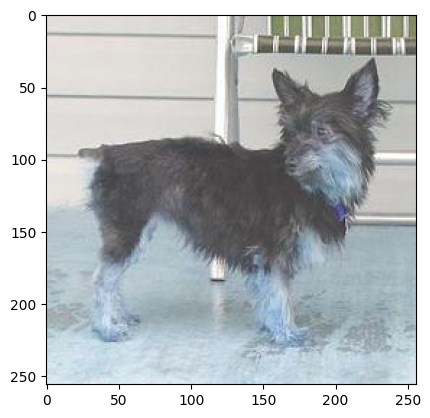

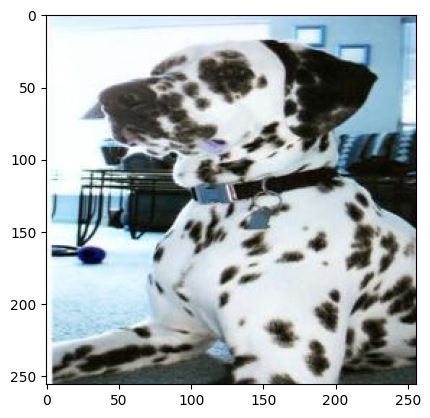

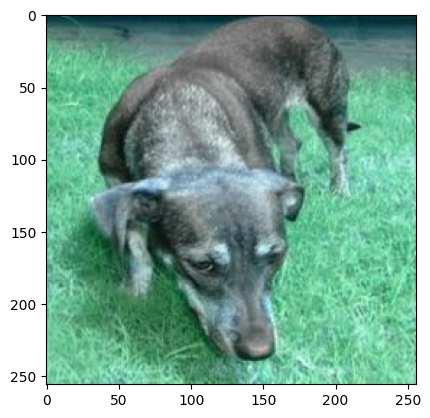

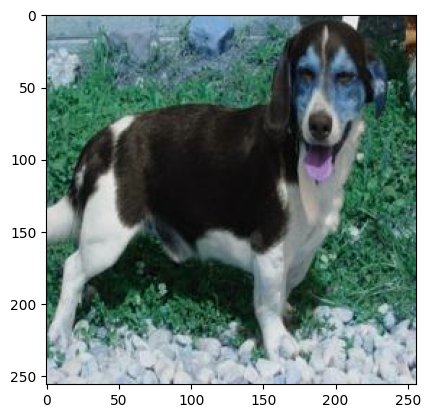

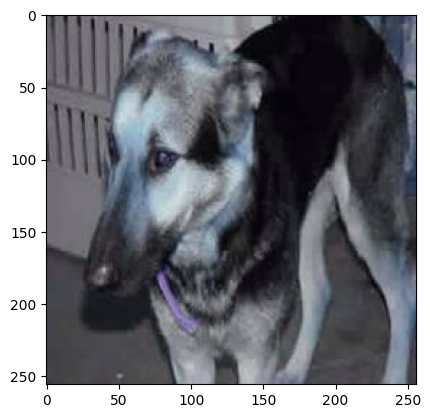

First 5 snakes images:


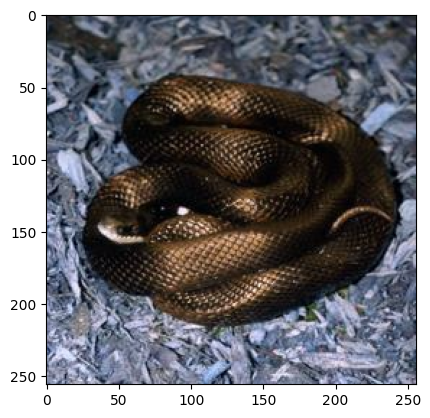

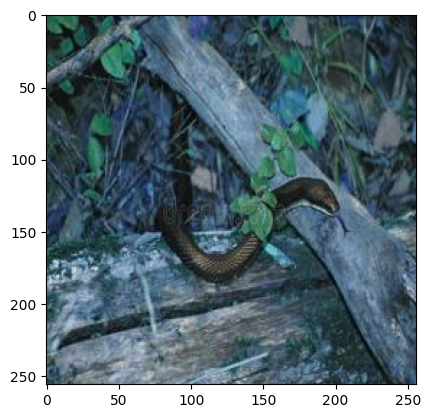

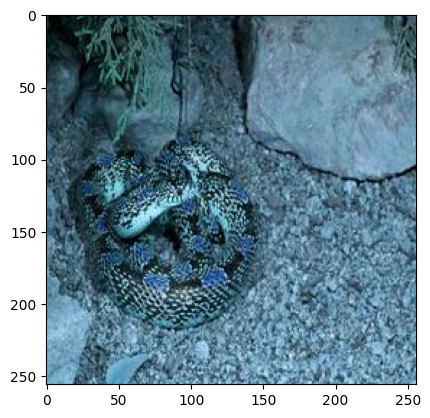

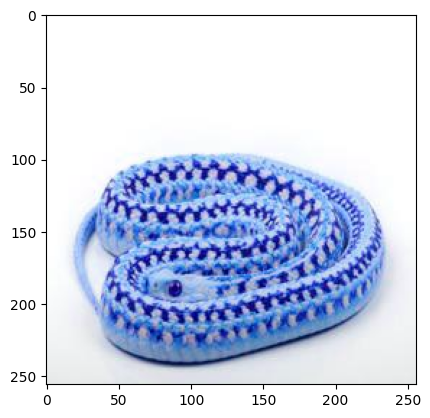

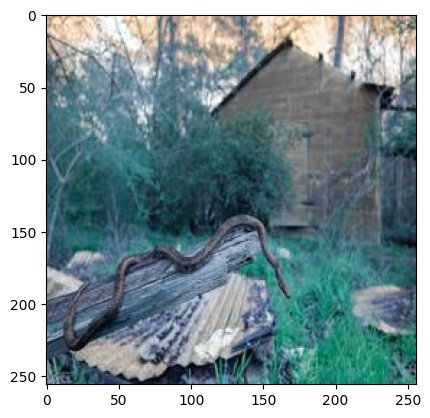

In [ ]:

# Membaca gambar dan label
imgs = []
lbls = []

for cate in fldr:
    folder_path = os.path.join(ds_path, cate)
    for image_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, image_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to load image '{img_path}'. Skipping this file.")
            continue
        img = cv2.resize(img, (sz, sz))
        imgs.append(img)
        lbls.append(fldr.index(cate))

print('Amount of Images:', len(imgs))
print('Amount of Labels:', len(lbls))

imgs = np.array(imgs)
lbls = np.array(lbls)

# One-hot encode labels
classes = tf.keras.utils.to_categorical(lbls, num_classes=len(fldr))
print(classes)

# Splitting Dataset (80% training, 20% testing)
xtr, xts, ytr, yts = tts(imgs, classes, test_size=0.20, random_state=rs)

print(f"\nTraining Set Size:\nX: {xtr.shape}\nY: {ytr.shape}")
print(f"\nTest Set Size:\nX: {xts.shape}\nY: {yts.shape}")

# Data Generators
tr_dtg = ImageDataGenerator(rescale=1./255, rotation_range=20, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
ts_dtg = ImageDataGenerator(rescale=1./255)

tr_g = tr_dtg.flow(xtr, ytr, batch_size=bs)
ts_g = ts_dtg.flow(xts, yts, batch_size=bs)

# Plotting Images
for cate in fldr:
        fl_path = os.path.join(ds_path, cate)
        print(f'First 5 {cate} images:')
        x=0
        for img in os.listdir(fl_path):
            img_path =os.path.join(fl_path, img)
            plt.imshow(cv2.imread(img_path))
            plt.show()
            x+=1
            if x==5:
                break


In [ ]:

# Loading ResNet50 Base Model
base_mod = ResNet50(weights='imagenet', include_top=False, input_shape=(sz, sz, 3))
for lyr in base_mod.layers:
    lyr.trainable = True

# LR Reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, mode='min')

# Model Building
mod = Sequential([
    base_mod,
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(fldr), activation='softmax')
])

mod.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = mod.fit(tr_g, epochs=30, validation_data=ts_g, verbose=1, callbacks=[reduce_lr])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 94s 376ms/step - accuracy: 0.6561 - loss: 1.0631 - val_accuracy: 0.3283 - val_loss: 130364.5234 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 226ms/step - accuracy: 0.5450 - loss: 1.2306 - val_accuracy: 0.3100 - val_loss: 166.8858 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.5901 - loss: 0.9087 - val_accuracy: 0.3617 - val_loss: 1.4115 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.6694 - loss: 0.7526 - val_accuracy: 0.3267 - val_loss: 1.1728 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 228ms/step - accuracy: 0.7003 - loss: 0.6451 - val_accuracy: 0.3617 - val_loss: 1.5968 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.7618 - loss: 0.5920 - val_accuracy: 0.4000 - val_loss: 1.0984 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 240ms/step - accuracy: 0.7995 - loss: 0.5252

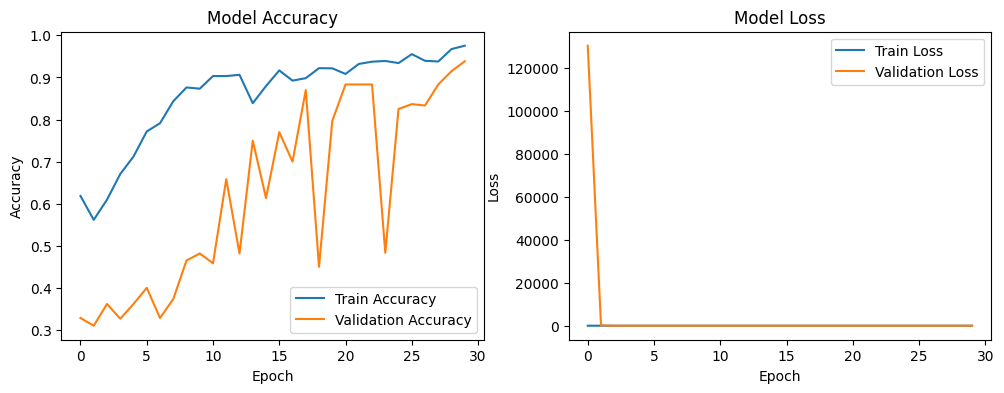

In [ ]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save the model in .keras format
saved_model_path = '/content/drive/MyDrive/dicoding-final/submission/saved_model/model.keras'
mod.save(saved_model_path)


# Simpan model dalam format .pb (SavedModel format)
saved_model_path_pb = os.path.join(saved_model_dir, 'saved_model_pb')
tf.saved_model.save(mod, saved_model_path_pb)

# Convert the model to TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(mod)
tflite_model = converter.convert()

# Save the TF-Lite model
with open('/content/drive/MyDrive/dicoding-final/submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model saved in .keras and TF-Lite format.")

Saved artifact at '/tmp/tmp_k9w3eiq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139568021356960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139568022648288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139568021576112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139568021580160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139568021577344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139568021578400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139568021888640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139568021890928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139568021888992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139568021892512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1395680218

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 113.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
import os
import tensorflow as tf
import tensorflowjs as tfjs

# Parameter
saved_model_file = '/content/drive/MyDrive/dicoding-final/submission/saved_model/model.keras'
tfjs_target_dir = '/content/drive/MyDrive/dicoding-final/submission/tfjs_model'

# Pastikan direktori target ada
os.makedirs(os.path.dirname(saved_model_file), exist_ok=True)
os.makedirs(tfjs_target_dir, exist_ok=True)

# Simpan model dalam format .keras
mod.save(saved_model_file)

# Konversi dari format .keras ke format tfjs
tfjs.converters.save_keras_model(mod, tfjs_target_dir)

print("Model berhasil dikonversi ke format TensorFlow.js dan disimpan di:", tfjs_target_dir)

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke format TensorFlow.js dan disimpan di: /content/drive/MyDrive/dicoding-final/submission/tfjs_model


In [ ]:
# Classification Report
from sklearn.metrics import confusion_matrix as cfs_mtx,classification_report

ts_img = np.concatenate([ts_g[i][0] for i in range(len(ts_g))])
y_pr = mod.predict(ts_img)
y_pr = np.argmax(y_pr,axis=1)

lbl = np.concatenate([ts_g[i][1] for i in range(len(ts_g))])
lbl = np.argmax(lbl,axis=1)

cls_rpt = classification_report(lbl,y_pr)
print('Classification Report: \n', cls_rpt)

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       217
           1       0.93      0.92      0.93       197
           2       0.94      0.99      0.96       186

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



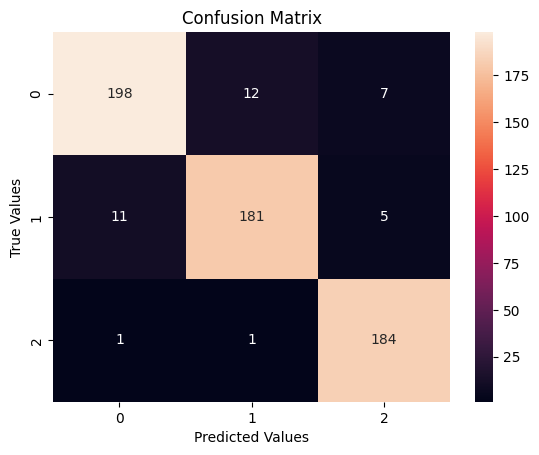

In [ ]:
# Confusion Matrix
import seaborn as sns

cm = cfs_mtx(lbl, y_pr)
sns.heatmap(cm,fmt='d', annot=True)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import subprocess

# Path untuk menyimpan requirements.txt
requirements_path = '/content/drive/MyDrive/dicoding-final/submission/requirements.txt'
result = subprocess.run(['pip', 'freeze'], stdout=subprocess.PIPE)

# Simpan daftar paket ke dalam file requirements.txt
with open(requirements_path, 'wb') as f:
    f.write(result.stdout)

print(f"File requirements.txt berhasil dibuat di: {requirements_path}")

File requirements.txt berhasil dibuat di: /content/drive/MyDrive/dicoding-final/submission/requirements.txt
